In [49]:
# Read data from Java SOMToolbox
from SOMToolBox_Parse import SOMToolBox_Parse
idata   = SOMToolBox_Parse("./datasets/chainlink/chainlink.vec").read_weight_file()
weights = SOMToolBox_Parse("./datasets/chainlink/chainlink.wgt.gz").read_weight_file()
classes = SOMToolBox_Parse("./datasets/chainlink/chainlink.cls").read_weight_file()

In [57]:
# Visualization by PySOMVis
from pysomvis import PySOMVis

vis = PySOMVis(weights=weights['arr'], m=weights['ydim'],n=weights['xdim'],
                dimension=weights['vec_dim'], input_data=idata['arr'],
                classes=classes['arr'][:,1], component_names=classes['classes_names'])
vis._mainview

Column
    [0] Column
        [0] Column
            [0] Row(margin=(5, 10), width=700)
                [0] StaticText(value='<b></b>')
                [1] Select(options=OrderedDict([('Component P...]), value=0)
                [2] Select(options=OrderedDict([('PiYG', ...]), value='jet')
                [3] Button(name='↶')
                [4] Button(name='↷')
                [5] Button(name='↔')
                [6] Button(name='↕')
                [7] Checkbox(name='interpolation')
        [1] Row
            [0] Column
                [0] HoloViews(DynamicMap, height=500, sizing_mode='fixed', width=500)
            [1] Row
                [0] Column
                    [0] Column(margin=(5, 10), name='Component Planes')
                        [0] StaticText(value='<b>Component Planes</b>')
                        [1] IntSlider(end=2, name='1')
                    [1] Str(str)
    [1] Column
        [0] Row()

In [56]:
# Use any library for training SOM map (e.x. MiniSOM, SOMOClu, SOMpy, PopSOM etc.)
from pysomvis import PySOMVis
from minisom import MiniSom    

som = MiniSom(100, 60, 3, sigma=20, learning_rate=0.7)
som.train(idata['arr'], 30000, random_order=True, verbose=True)

vis = PySOMVis(weights=som._weights, input_data=idata['arr'])
vis._mainview

 [ 30000 / 30000 ] 100% - 0:00:00 left 
 quantization error: 0.07189397654763587


Column
    [0] Column
        [0] Column
            [0] Row(margin=(5, 10), width=700)
                [0] StaticText(value='<b></b>')
                [1] Select(options=OrderedDict([('Component P...]), value=0)
                [2] Select(options=OrderedDict([('PiYG', ...]), value='jet')
                [3] Button(name='↶')
                [4] Button(name='↷')
                [5] Button(name='↔')
                [6] Button(name='↕')
                [7] Checkbox(name='interpolation')
        [1] Row
            [0] Column
                [0] HoloViews(DynamicMap, height=500, sizing_mode='fixed', width=500)
            [1] Row
                [0] Column
                    [0] Column(margin=(5, 10), name='Component Planes')
                        [0] StaticText(value='<b>Component Planes</b>')
                        [1] IntSlider(end=2, name='Component')
                    [1] Str(str)
    [1] Column
        [0] Row()

In [74]:
topographic_error = som.topographic_error(idata["arr"])

In [75]:
quantization_error = som.quantization_error(idata["arr"])

In [65]:
import numpy as np
quantization_error= np.mean([np.linalg.norm(x - som._weights[som.winner(x)]) for x in idata["arr"]])

In [66]:
topographic_error = np.mean([
    np.linalg.norm(np.array(som.winner(x)) - np.array(som.winner(y))) for x, y in zip(idata["arr"][:-1], idata["arr"][1:])
])

In [73]:
topographic_product = (som.quantization_error(idata["arr"]) + som.topographic_error(idata["arr"])) / 2

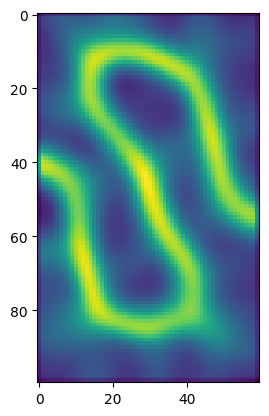

In [76]:
import matplotlib.pyplot as plt
plt.imshow(som.distance_map())

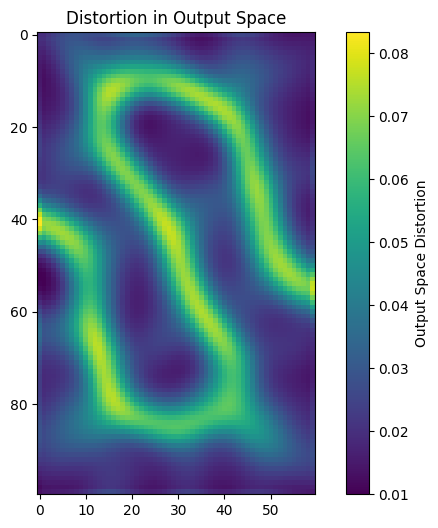

In [77]:
grid_x, grid_y = som._weights.shape[:2]  # Extract SOM grid dimensions
output_distances = np.zeros((grid_x, grid_y))
for i in range(grid_x):
    for j in range(grid_y):
        # Calculate the average distance between a neuron and its neighbors
        neighbors = [
            (i - 1, j), (i + 1, j), (i, j - 1), (i, j + 1)  # Up, Down, Left, Right
        ]
        valid_neighbors = [
            som._weights[n[0], n[1]] for n in neighbors if 0 <= n[0] < grid_x and 0 <= n[1] < grid_y
        ]
        output_distances[i, j] = np.mean([
            np.linalg.norm(som._weights[i, j] - neighbor) for neighbor in valid_neighbors
        ])

plt.figure(figsize=(8, 6))
plt.title("Distortion in Output Space")
plt.imshow(output_distances, cmap='viridis')  # Heatmap for output distortion
plt.colorbar(label='Output Space Distortion')
plt.show()

0.030017478819410845


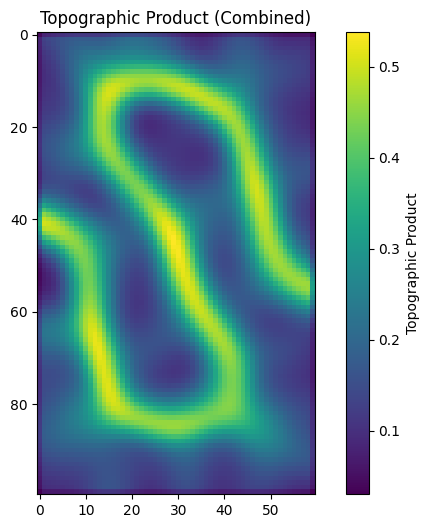

Quantization Error (Input Distortion): 0.0719
Topographic Error (Output Distortion): 0.0350
Topographic Product: 0.0534


In [83]:
topographic_map = (som.distance_map() + output_distances) / 2  # Mean of the two
print(np.min(topographic_map))
plt.figure(figsize=(8, 6))
plt.title("Topographic Product (Combined)")
plt.imshow(topographic_map, cmap='viridis')
plt.colorbar(label='Topographic Product')
plt.show()

# Print calculated values for reference
print(f"Quantization Error (Input Distortion): {quantization_error:.4f}")
print(f"Topographic Error (Output Distortion): {topographic_error:.4f}")
print(f"Topographic Product: {topographic_product:.4f}")